In [503]:
from math import log, exp
import itertools
import math
import random
import scipy

class GSOM_Node:
    R = random.Random()
    
    def __init__(self, dim, x, y):
        # Create a weight vector of the given dimension:
        # Initialize the weight vector with random values between 0 and 1.
        self.weights=scipy.array([self.R.random() for _ in range(dim)])

        self.error = 0.0

        self.it = 0
        self.last_it = 0

        self.data = None
        self.last_changed = 0

        self.right = None
        self.left  = None
        self.up    = None
        self.down  = None

        self.x, self.y = x, y


    def adjust_weights(self, target, learn_rate):
        """ Adjust the weights of this node. """
        for w in range(0, len(target)):
            self.weights[w] += learn_rate * (target[w] - self.weights[w])


    def is_boundary(self):
        """ Check if this node is at the boundary of the map. """
        if not self.right: return True
        if not self.left:  return True
        if not self.up:    return True
        if not self.down:  return True
        return False



In [504]:
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import iris data
iris = datasets.load_iris()
dataset = iris
spread_factor = 1.5
# Assign the data
data = []
for fn in dataset:
    t = dataset
    arr = scipy.array(t.data)
    data.append([fn,arr])

# Determine the dimension of the data.
dim = len(data[0][1])

# Calculate the growing threshold:
_GT = -dim * math.log(spread_factor, 2)

# Create the 4 starting Nodes.
nodes = []
n00 = GSOM_Node(dim, 10, 10)
n01 = GSOM_Node(dim, 10, 11)
n10 = GSOM_Node(dim, 11, 10)
n11 = GSOM_Node(dim, 11, 11)
nodes.extend([n00,n01,n10,n11])

# Create starting topology
n00.right = n10
n00.up    = n01
n01.right = n11
n01.down  = n00
n10.up    = n11
n10.left  = n00
n11.left  = n01
n11.down  = n10

# Set properties
it = 0       # Current iteration
max_it = len(data)
num_it = 100     # Total iterations
init_lr = 0.5     # Initial value of the learning rate
alpha = 0.2
output = file = open("gsom.csv","w")

print(len(n00.weights))

150


In [415]:
def _distance(v1, v2):
    dist = 0.0
    #print(v1)
    #print(v2)
    for v, w in zip(v1, v2):
        dist += pow(v - w,2)
    return dist


def _find_bmu(vec):
    dist=float("inf")
    winner = False
    for node in nodes:
        d = _distance(vec, node.weights)
        #print(d.all())            
        if(d < dist):
            dist = d
            winner = node

    return winner


def _find_similar_boundary(node):
    dist = float("inf")
    winner = False
    for boundary in nodes:
        if not boundary.is_boundary(): continue
        if boundary == node: continue

        d = _distance(node.weights, boundary.weights)
        if d < dist:
            dist = d
            winner = node

    return winner

In [79]:
def _node_add_error(node, error):

    node.error += error

    # Consider growing
    if node.error > _GT:
        if not node.is_boundary():
            node = _find_similar_boundary(node)
            if not node:
                print("GSOM: Error: No free boundary node found!")

        nodes = _grow(node)
        return True, nodes

    return False, 0


def _grow(node):
    """ Grow this GSOM. """
    # We grow this GSOM in every possible direction.
    nodes = []
    if node.left == None:
        nn = _insert(node.x - 1, node.y, node)
        nodes.append(nn)
        print("Growing left at: (" + str(node.x) + "," + str(node.y)\
                + ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")

    if node.right == None:
        nn = _insert(node.x + 1, node.y, node)
        nodes.append(nn)
        print("Growing right at: (" + str(node.x) + "," + str(node.y)\
                + ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")

    if node.up == None:
        nn = _insert(node.x, node.y + 1, node)
        nodes.append(nn)
        print("Growing up at: (" + str(node.x) + "," + str(node.y) +\
                ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")

    if node.down == None:
        nn = _insert(node.x, node.y - 1, node)
        nodes.append(nn)
        print("Growing down at: (" + str(node.x) + "," + str(node.y) +\
                ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")
    return nodes


def _insert(x, y, init_node):
    # Create new node
    new_node = GSOM_Node(dim, x, y)
    nodes.append(new_node)

    new_node.it = new_node.last_it = it

    # Create the connections to possible neighbouring nodes.
    for node in nodes:
        # Left, Right, Up, Down
        if node.x == x - 1 and node.y == y:
            new_node.left = node
            node.right = new_node
        if node.x == x + 1 and node.y == y:
            new_node.right = node
            node.left = new_node
        if node.x == x and node.y == y + 1:
            new_node.up = node
            node.down = new_node
        if node.x == x and node.y == y - 1:
            new_node.down = node
            node.up = new_node

    # Calculate new weights, look for a neighbour.
    neigh = new_node.left
    if neigh == None: neigh = new_node.right
    if neigh == None: neigh = new_node.up
    if neigh == None: neigh = new_node.down
    if neigh == None: print("_insert: No neighbour found!")

    for i in range(0, len(new_node.weights)):
        new_node.weights[i] = 2 * init_node.weights[i] - neigh.weights[i]

    return new_node


def _remove_unused_nodes():
    """ Remove all nodes from the GSOM that have not been used. """
    to_remove = []

    # Iterate over all nodes.
    for node in nodes:
        iterations_not_won = it - node.last_it
        if iterations_not_won < len(nodes) * 4.0 * (1 + it/len(data)) : continue

        if node.left:  node.left.right = None
        if node.up:    node.up.down    = None
        if node.down:  node.down.up    = None
        if node.right: node.right.left = None

        to_remove.append(node)

    # Now remove all marked nodes.
    for node in to_remove:
        print("Removing node @ " + str(node.x) + ", " + str(node.y) + \
              " - Current it: " + str(it) + " - Last time won: " +\
              str(node.last_it))
        if node.data:
            output.write(node.data + "," + str(node.x)+","+str(node.y)\
                + ",remove\n")
    nodes.remove(node)

In [80]:
## training & viz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [264]:
input[0:50].shape

(50, 4)

In [487]:
input = random.choice(data)[1]
learn_rate = init_lr * alpha * (1 - 3.8/len(nodes))

recalc_nodes = []
for _ in range(100):
    # best matching unit
    l0 = [i[0] for i in input]
    l1 = [i[1] for i in input]
    l2 = [i[2] for i in input]
    l3 = [i[3] for i in input]
    #print(l0)
    
    BMU = _find_bmu(l0)
    BMU.last_it = it

    # Adapt the weights of the direct topological neighbours
    neighbours = []
    neighbours.append(BMU)
    if BMU.left:  neighbours.append(BMU.left)
    if BMU.right: neighbours.append(BMU.right)
    if BMU.up:    neighbours.append(BMU.up)
    if BMU.down:  neighbours.append(BMU.down)

    if BMU not in recalc_nodes: recalc_nodes.append(BMU)

    for node in neighbours:
        node.adjust_weights(l0, learn_rate)
        if node not in recalc_nodes: recalc_nodes.append(node)

    # Calculate the error.
    err = _distance(BMU.weights, l0)

    # Add the error to the node.
    growing, nodes = _node_add_error(BMU, err)
    if growing: recalc_nodes.extend(nodes)

    # Count the iteration
    it += 1

    # Re-Calc representative data elements for changed nodes.
    used_data = []
    for node in nodes:
        used_data.append(node.data)

    for node in recalc_nodes:
        dist = float("inf")
        winner = False
        winner_fn = False
    
        for fn,point in data:
            if fn in used_data: continue

            point0 = [i[0] for i in point]
            d = _distance(point0, node.weights)
            if(d < dist):
                dist = d
                winner = point0
                winner_fn = fn

        if node.data != winner_fn:
            node.data = winner_fn
            node.last_changed = it
        output.write(str(node.data) + "," + str(node.x) + "," + str(node.y)\
                + ",change\n")
        used_data.append(winner_fn)

    # Remove unused nodes.
    _remove_unused_nodes()

    


Growing left at: (10,11) -> (9, 11)
Growing up at: (10,11) -> (10, 12)
Growing left at: (9,11) -> (8, 11)
Growing up at: (9,11) -> (9, 12)
Growing down at: (9,11) -> (9, 10)
Growing left at: (8,11) -> (7, 11)
Growing up at: (8,11) -> (8, 12)
Growing down at: (8,11) -> (8, 10)
Growing left at: (8,12) -> (7, 12)
Growing up at: (8,12) -> (8, 13)
Growing left at: (7,12) -> (6, 12)
Growing up at: (7,12) -> (7, 13)
Growing left at: (6,12) -> (5, 12)
Growing up at: (6,12) -> (6, 13)
Growing down at: (6,12) -> (6, 11)
Growing left at: (5,12) -> (4, 12)
Growing up at: (5,12) -> (5, 13)
Growing down at: (5,12) -> (5, 11)
Growing left at: (5,13) -> (4, 13)
Growing up at: (5,13) -> (5, 14)
Growing left at: (4,13) -> (3, 13)
Growing up at: (4,13) -> (4, 14)
Growing left at: (3,13) -> (2, 13)
Growing up at: (3,13) -> (3, 14)
Growing down at: (3,13) -> (3, 12)
Growing left at: (2,13) -> (1, 13)
Growing up at: (2,13) -> (2, 14)
Growing down at: (2,13) -> (2, 12)
Growing left at: (2,14) -> (1, 14)
Grow

In [488]:
import pandas as pd
df = pd.read_csv('gsom.csv')
print(df.shape)
df.columns

(12816, 4)


Index(['feature_names', '10', '11', 'change'], dtype='object')

In [489]:
x1 = df['10']
y1 = df['11']

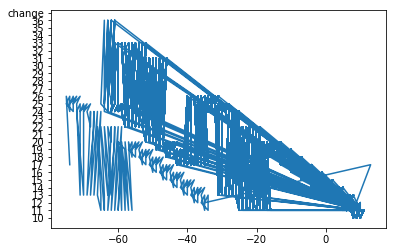

In [490]:
plt.plot(x1,y1)

In [493]:
input = random.choice(data)[1]
learn_rate = init_lr * alpha * (1 - 3.8/len(nodes))

recalc_nodes = []
for _ in range(100):
    # best matching unit
    l0 = [i[0] for i in input]
    l1 = [i[1] for i in input]
    l2 = [i[2] for i in input]
    l3 = [i[3] for i in input]
    #print(l0)
    
    BMU = _find_bmu(l1)
    BMU.last_it = it

    # Adapt the weights of the direct topological neighbours
    neighbours = []
    neighbours.append(BMU)
    if BMU.left:  neighbours.append(BMU.left)
    if BMU.right: neighbours.append(BMU.right)
    if BMU.up:    neighbours.append(BMU.up)
    if BMU.down:  neighbours.append(BMU.down)

    if BMU not in recalc_nodes: recalc_nodes.append(BMU)

    for node in neighbours:
        node.adjust_weights(l1, learn_rate)
        if node not in recalc_nodes: recalc_nodes.append(node)

    # Calculate the error.
    err = _distance(BMU.weights, l1)

    # Add the error to the node.
    growing, nodes = _node_add_error(BMU, err)
    if growing: recalc_nodes.extend(nodes)

    # Count the iteration
    it += 1

    # Re-Calc representative data elements for changed nodes.
    used_data = []
    for node in nodes:
        used_data.append(node.data)

    for node in recalc_nodes:
        dist = float("inf")
        winner = False
        winner_fn = False
    
        for fn,point in data:
            if fn in used_data: continue

            point1 = [i[1] for i in point]
            d = _distance(point1, node.weights)
            if(d < dist):
                dist = d
                winner = point1
                winner_fn = fn

        if node.data != winner_fn:
            node.data = winner_fn
            node.last_changed = it
        output.write(str(node.data) + "," + str(node.x) + "," + str(node.y)\
                + ",change\n")
        used_data.append(winner_fn)

    # Remove unused nodes.
    _remove_unused_nodes()

    


Growing right at: (11,11) -> (12, 11)
Growing up at: (11,11) -> (11, 12)
Growing right at: (12,11) -> (13, 11)
Growing up at: (12,11) -> (12, 12)
Growing down at: (12,11) -> (12, 10)
Growing right at: (13,11) -> (14, 11)
Growing up at: (13,11) -> (13, 12)
Growing down at: (13,11) -> (13, 10)
Growing right at: (13,12) -> (14, 12)
Growing up at: (13,12) -> (13, 13)
Growing right at: (14,12) -> (15, 12)
Growing up at: (14,12) -> (14, 13)
Growing right at: (15,12) -> (16, 12)
Growing up at: (15,12) -> (15, 13)
Growing down at: (15,12) -> (15, 11)
Growing right at: (16,12) -> (17, 12)
Growing up at: (16,12) -> (16, 13)
Growing down at: (16,12) -> (16, 11)
Growing right at: (16,13) -> (17, 13)
Growing up at: (16,13) -> (16, 14)
Growing right at: (17,13) -> (18, 13)
Growing up at: (17,13) -> (17, 14)
Growing right at: (18,13) -> (19, 13)
Growing up at: (18,13) -> (18, 14)
Growing down at: (18,13) -> (18, 12)
Growing right at: (19,13) -> (20, 13)
Growing up at: (19,13) -> (19, 14)
Growing down

In [494]:
import pandas as pd
df = pd.read_csv('gsom.csv')
print(df.shape)
df.columns

(13117, 4)


Index(['feature_names', '11', '11.1', 'change'], dtype='object')

In [495]:
x2 = df['11']
y2 = df['11.1']

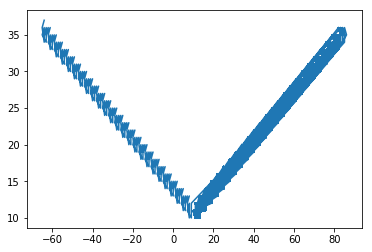

In [496]:
plt.plot(x2,y2)

In [499]:
input = random.choice(data)[1]
learn_rate = init_lr * alpha * (1 - 3.8/len(nodes))

recalc_nodes = []
for _ in range(100):
    # best matching unit
    l0 = [i[0] for i in input]
    l1 = [i[1] for i in input]
    l2 = [i[2] for i in input]
    l3 = [i[3] for i in input]
    #print(l0)
    
    BMU = _find_bmu(l2)
    BMU.last_it = it

    # Adapt the weights of the direct topological neighbours
    neighbours = []
    neighbours.append(BMU)
    if BMU.left:  neighbours.append(BMU.left)
    if BMU.right: neighbours.append(BMU.right)
    if BMU.up:    neighbours.append(BMU.up)
    if BMU.down:  neighbours.append(BMU.down)

    if BMU not in recalc_nodes: recalc_nodes.append(BMU)

    for node in neighbours:
        node.adjust_weights(l2, learn_rate)
        if node not in recalc_nodes: recalc_nodes.append(node)

    # Calculate the error.
    err = _distance(BMU.weights, l2)

    # Add the error to the node.
    growing, nodes = _node_add_error(BMU, err)
    if growing: recalc_nodes.extend(nodes)

    # Count the iteration
    it += 1

    # Re-Calc representative data elements for changed nodes.
    used_data = []
    for node in nodes:
        used_data.append(node.data)

    for node in recalc_nodes:
        dist = float("inf")
        winner = False
        winner_fn = False
    
        for fn,point in data:
            if fn in used_data: continue

            point2 = [i[2] for i in point]
            d = _distance(point2, node.weights)
            if(d < dist):
                dist = d
                winner = point2
                winner_fn = fn

        if node.data != winner_fn:
            node.data = winner_fn
            node.last_changed = it
        output.write(str(node.data) + "," + str(node.x) + "," + str(node.y)\
                + ",change\n")
        used_data.append(winner_fn)

    # Remove unused nodes.
    _remove_unused_nodes()

    


Growing right at: (11,10) -> (12, 10)
Growing down at: (11,10) -> (11, 9)
Growing right at: (12,10) -> (13, 10)
Growing up at: (12,10) -> (12, 11)
Growing down at: (12,10) -> (12, 9)
Growing right at: (13,10) -> (14, 10)
Growing up at: (13,10) -> (13, 11)
Growing down at: (13,10) -> (13, 9)
Growing right at: (13,11) -> (14, 11)
Growing up at: (13,11) -> (13, 12)
Growing right at: (14,11) -> (15, 11)
Growing up at: (14,11) -> (14, 12)
Growing right at: (15,11) -> (16, 11)
Growing up at: (15,11) -> (15, 12)
Growing down at: (15,11) -> (15, 10)
Growing right at: (16,11) -> (17, 11)
Growing up at: (16,11) -> (16, 12)
Growing down at: (16,11) -> (16, 10)
Growing right at: (16,12) -> (17, 12)
Growing up at: (16,12) -> (16, 13)
Growing right at: (17,12) -> (18, 12)
Growing up at: (17,12) -> (17, 13)
Growing right at: (18,12) -> (19, 12)
Growing up at: (18,12) -> (18, 13)
Growing down at: (18,12) -> (18, 11)
Growing right at: (19,12) -> (20, 12)
Growing up at: (19,12) -> (19, 13)
Growing down 

In [500]:
import pandas as pd
df = pd.read_csv('gsom.csv')
print(df.shape)
df.columns

(12937, 4)


Index(['feature_names', '11', '10', 'change'], dtype='object')

In [501]:
x3 = df['11']
y3 = df['10']

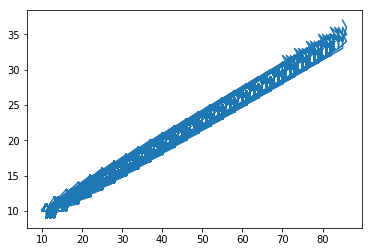

In [502]:
plt.plot(x3,y3)

In [52]:
x = [i[3] for i in input]

In [505]:
input = random.choice(data)[1]
learn_rate = init_lr * alpha * (1 - 3.8/len(nodes))

recalc_nodes = []
for _ in range(100):
    # best matching unit
    l0 = [i[0] for i in input]
    l1 = [i[1] for i in input]
    l2 = [i[2] for i in input]
    l3 = [i[3] for i in input]
    #print(l0)
    
    BMU = _find_bmu(l3)
    BMU.last_it = it

    # Adapt the weights of the direct topological neighbours
    neighbours = []
    neighbours.append(BMU)
    if BMU.left:  neighbours.append(BMU.left)
    if BMU.right: neighbours.append(BMU.right)
    if BMU.up:    neighbours.append(BMU.up)
    if BMU.down:  neighbours.append(BMU.down)

    if BMU not in recalc_nodes: recalc_nodes.append(BMU)

    for node in neighbours:
        node.adjust_weights(l3, learn_rate)
        if node not in recalc_nodes: recalc_nodes.append(node)

    # Calculate the error.
    err = _distance(BMU.weights, l3)

    # Add the error to the node.
    growing, nodes = _node_add_error(BMU, err)
    if growing: recalc_nodes.extend(nodes)

    # Count the iteration
    it += 1

    # Re-Calc representative data elements for changed nodes.
    used_data = []
    for node in nodes:
        used_data.append(node.data)

    for node in recalc_nodes:
        dist = float("inf")
        winner = False
        winner_fn = False
    
        for fn,point in data:
            if fn in used_data: continue

            point3 = [i[3] for i in point]
            d = _distance(point3, node.weights)
            if(d < dist):
                dist = d
                winner = point3
                winner_fn = fn

        if node.data != winner_fn:
            node.data = winner_fn
            node.last_changed = it
        output.write(str(node.data) + "," + str(node.x) + "," + str(node.y)\
                + ",change\n")
        used_data.append(winner_fn)

    # Remove unused nodes.
    _remove_unused_nodes()


Growing left at: (10,11) -> (9, 11)
Growing up at: (10,11) -> (10, 12)
Growing left at: (9,11) -> (8, 11)
Growing up at: (9,11) -> (9, 12)
Growing down at: (9,11) -> (9, 10)
Growing left at: (8,11) -> (7, 11)
Growing up at: (8,11) -> (8, 12)
Growing down at: (8,11) -> (8, 10)
Growing left at: (8,12) -> (7, 12)
Growing up at: (8,12) -> (8, 13)
Growing left at: (7,12) -> (6, 12)
Growing up at: (7,12) -> (7, 13)
Growing left at: (6,12) -> (5, 12)
Growing up at: (6,12) -> (6, 13)
Growing down at: (6,12) -> (6, 11)
Growing left at: (5,12) -> (4, 12)
Growing up at: (5,12) -> (5, 13)
Growing down at: (5,12) -> (5, 11)
Growing left at: (5,13) -> (4, 13)
Growing up at: (5,13) -> (5, 14)
Growing left at: (4,13) -> (3, 13)
Growing up at: (4,13) -> (4, 14)
Growing left at: (3,13) -> (2, 13)
Growing up at: (3,13) -> (3, 14)
Growing down at: (3,13) -> (3, 12)
Growing left at: (2,13) -> (1, 13)
Growing up at: (2,13) -> (2, 14)
Growing down at: (2,13) -> (2, 12)
Growing left at: (2,14) -> (1, 14)
Grow

In [506]:
import pandas as pd
df = pd.read_csv('gsom.csv')
print(df.shape)
df.columns

(12710, 4)


Index(['feature_names', '10', '11', 'change'], dtype='object')

In [507]:
x4 = df['10']
y4 = df['11']

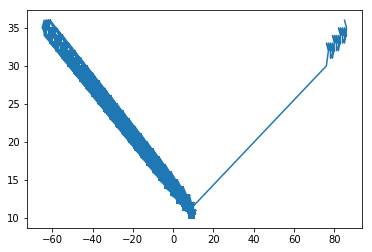

In [508]:
plt.plot(x4,y4)

In [509]:
%matplotlib inline

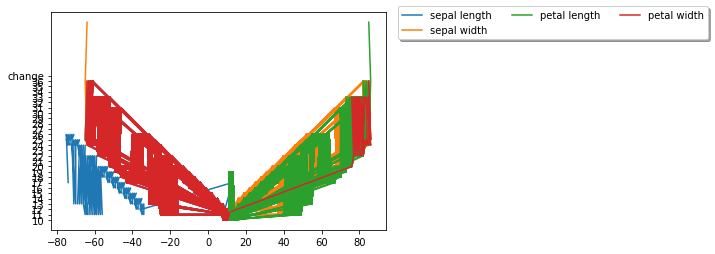

In [511]:
plt.plot(x1, y1, label='sepal length')
plt.plot(x2, y2, label='sepal width')
plt.plot(x3, y3, label='petal length')
plt.plot(x4,y4, label='petal width')


plt.legend(('sepal length', 'sepal width', 'petal length', 'petal width'))
plt.legend(loc='upper center', bbox_to_anchor=(1.50, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


fig = plt.figure()
plt.ylim(-50, 50)
plt.xlim(-50, 50)
graph1, = plt.plot([], [], 'o')
graph2, = plt.plot([], [], '-')
graph3, = plt.plot([], [], '>')
graph4, = plt.plot([], [], '|')

def animate1(i):
    graph1.set_data(x1[:i+1], y1[:i+1])
    return graph1

def animate2(i):
    graph2.set_data(x2[:i+1], y2[:i+1])
    return graph2

def animate3(i):
    graph3.set_data(x3[:i+1], y3[:i+1])
    return graph3

def animate4(i):
    graph4.set_data(x4[:i+1], y4[:i+1])
    return graph4


ani1 = FuncAnimation(fig, animate1(200000))
ani2 = FuncAnimation(fig, animate2(200000))
ani3 = FuncAnimation(fig, animate3(200000))
ani4 = FuncAnimation(fig, animate4(200000))

plt.show()

AttributeError: 'NoneType' object has no attribute 'seq'

In [140]:
# viz needs more iterations for better understanding, will add more. 
# currently causing bugs after a limit

In [144]:
## understanding output file


In [145]:
df.describe() # basic description of variables present

# 1 and 0 represent the x and y coordinates of the winner node

,1,0
count,1.298399e+06,1.298398e+06
mean,6.697577e+02,9.539206e+01
std,3.059955e+02,5.351747e+01
min,0.000000e+00,-1.000000e+00
25%,3.890000e+02,5.100000e+01
50%,7.350000e+02,7.900000e+01
75%,8.940000e+02,1.310000e+02
max,1.275000e+03,2.590000e+02


In [146]:
df.head(10) # first 10 records

,target_names,1,0,change
0,data,0,0.0,change
1,target,1,1.0,change
2,DESCR,2,0.0,change
3,feature_names,1,-1.0,change
4,target_names,1,0.0,change
5,data,0,0.0,change
6,target,1,1.0,change
7,DESCR,2,0.0,change
8,feature_names,1,-1.0,change
9,False,3,0.0,change


In [147]:
df.head(-20)

,target_names,1,0,change
0,data,0,0.0,change
1,target,1,1.0,change
2,DESCR,2,0.0,change
3,feature_names,1,-1.0,change
4,target_names,1,0.0,change
5,data,0,0.0,change
6,target,1,1.0,change
7,DESCR,2,0.0,change
8,feature_names,1,-1.0,change
9,False,3,0.0,change


In [131]:
## debugging

In [132]:
i = 0
for _ in range(20):
    l0 = [i[0] for i in input]
    print(l0)
    BMU = _find_bmu(l0)

[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.6, 5.0, 4.4, 4.9, 5.4, 4.8, 4.8, 4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5.0, 5.0, 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5.0, 5.5, 4.9, 4.4, 5.1, 5.0, 4.5, 4.4, 5.0, 5.1, 4.8, 5.1, 4.6, 5.3, 5.0, 7.0, 6.4, 6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5.0, 5.9, 6.0, 6.1, 5.6, 6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7, 6.0, 5.7, 5.5, 5.5, 5.8, 6.0, 5.4, 6.0, 6.7, 6.3, 5.6, 5.5, 5.5, 6.1, 5.8, 5.0, 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3, 6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5, 7.7, 7.7, 6.0, 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2, 7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6.0, 6.9, 6.7, 6.9, 5.8, 6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9]


TypeError: 'int' object is not iterable

In [146]:
    l0 = [i[0] for i in input]
    print(l0)
    BMU = _find_bmu(l0)
    print(BMU)

[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.6, 5.0, 4.4, 4.9, 5.4, 4.8, 4.8, 4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5.0, 5.0, 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5.0, 5.5, 4.9, 4.4, 5.1, 5.0, 4.5, 4.4, 5.0, 5.1, 4.8, 5.1, 4.6, 5.3, 5.0, 7.0, 6.4, 6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5.0, 5.9, 6.0, 6.1, 5.6, 6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7, 6.0, 5.7, 5.5, 5.5, 5.8, 6.0, 5.4, 6.0, 6.7, 6.3, 5.6, 5.5, 5.5, 6.1, 5.8, 5.0, 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3, 6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5, 7.7, 7.7, 6.0, 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2, 7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6.0, 6.9, 6.7, 6.9, 5.8, 6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9]
<__main__.GSOM_Node instance at 0x7f9b002b8518>


In [147]:
for fn,point in data:
    if fn in used_data: continue
    print(node.weights)

In [257]:
# sepal length sepal width petal length petal width
# Iris-Setosa - Iris-Versicolour - Iris-Virginica

In [256]:
dataset

{'DESCR': 'Iris Plants Database\n====================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)\n    ============== ==== ==== ======= ===== ==